In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
#load the data
credit_card_default_train = pd.read_csv('/content/drive/My Drive/credit_card_default_train.csv',header=0)
credit_card_default_test = pd.read_csv('/content/drive/My Drive/credit_card_default_test.csv',header=0)

# Feature Engineering

In [0]:
import sklearn
from sklearn.preprocessing import LabelEncoder

df = credit_card_default_train.drop('Client_ID', axis =1)
df.head()

# make the 'Balance_Limit_V1' data numeric (remove 'M's and 'K's available)
def balance_limit_encoder(value):
    last = value[-1]
    value = value[:-1]
    int_val = 0
    if last == 'K':
        int_val = float(value) * 1e3
    elif last == 'M':
        int_val = float(value) * 1e6
    return int_val

df_new = df.assign(Balance_Limit_Enc = train['Balance_Limit_V1'].map(balance_limit_encoder))
del df_new['Balance_Limit_V1']
dum_list = ['Gender',	'EDUCATION_STATUS','AGE','MARITAL_STATUS','PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']

# create dummies
for i in dum_list:
    dummies = pd.get_dummies(df_new[str(i)],drop_first=True).rename(columns=lambda x: str(i)+'_' + str(x))
    df_new = pd.concat([df_new, dummies], axis=1)

# Now drop original columns that were dummified 
new_drop = ['Gender', 'EDUCATION_STATUS', 'AGE','MARITAL_STATUS', 'PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']
df_new.drop(new_drop, axis=1, inplace=True)

# Drop any duplicate columns from concat
df_new = train_new.loc[:,~train_new.columns.duplicated()]

#So all the available categorical data are dummified

In [26]:
df_new.head()

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,NEXT_MONTH_DEFAULT,Balance_Limit_Enc,Gender_M,EDUCATION_STATUS_High School,EDUCATION_STATUS_Other,AGE_46-65,AGE_Less than 30,AGE_More than 65,MARITAL_STATUS_Single,PAY_JULY_-1,PAY_JULY_0,PAY_JULY_1,PAY_JULY_2,PAY_JULY_3,PAY_JULY_4,PAY_JULY_5,PAY_JULY_6,PAY_JULY_7,PAY_JULY_8,PAY_AUG_-1,PAY_AUG_0,PAY_AUG_1,PAY_AUG_2,PAY_AUG_3,PAY_AUG_4,PAY_AUG_5,PAY_AUG_6,PAY_AUG_7,PAY_AUG_8,PAY_SEP_-1,PAY_SEP_0,PAY_SEP_1,PAY_SEP_2,PAY_SEP_3,PAY_SEP_4,PAY_SEP_5,PAY_SEP_6,PAY_SEP_7,PAY_SEP_8,PAY_OCT_-1,PAY_OCT_0,PAY_OCT_1,PAY_OCT_2,PAY_OCT_3,PAY_OCT_4,PAY_OCT_5,PAY_OCT_6,PAY_OCT_7,PAY_OCT_8,PAY_NOV_-1,PAY_NOV_0,PAY_NOV_2,PAY_NOV_3,PAY_NOV_4,PAY_NOV_5,PAY_NOV_6,PAY_NOV_7,PAY_NOV_8,PAY_DEC_-1,PAY_DEC_0,PAY_DEC_2,PAY_DEC_3,PAY_DEC_4,PAY_DEC_5,PAY_DEC_6,PAY_DEC_7,PAY_DEC_8
0,3248,3389,6004,39418,162772,-13982,3437,6004,39418,162772,0,538165,0,1000000.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,353351,151818,26948,43530,80811,124590,151818,46200,43530,80811,942,33666,0,1000000.0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,16681,16082,15477,0,0,0,0,0,0,0,0,0,1,100000.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,90457,92848,95193,97309,100353,102740,3855,3890,3696,4620,4049,3918,1,200000.0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,429556,419466,429785,435354,445271,453899,0,20790,16170,17325,16401,17325,0,1000000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
#test-train split

from sklearn.model_selection import train_test_split

X = df_new.drop('NEXT_MONTH_DEFAULT', axis =1)
y = df_new.loc[:,'NEXT_MONTH_DEFAULT']

X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#train split has only numerical and dummified data

pd.DataFrame(X_train).head()

,DUE_AMT_JULY,DUE_AMT_AUG,DUE_AMT_SEP,DUE_AMT_OCT,DUE_AMT_NOV,DUE_AMT_DEC,PAID_AMT_JULY,PAID_AMT_AUG,PAID_AMT_SEP,PAID_AMT_OCT,PAID_AMT_NOV,PAID_AMT_DEC,Balance_Limit_Enc,Gender_M,EDUCATION_STATUS_High School,EDUCATION_STATUS_Other,AGE_46-65,AGE_Less than 30,AGE_More than 65,MARITAL_STATUS_Single,PAY_JULY_-1,PAY_JULY_0,PAY_JULY_1,PAY_JULY_2,PAY_JULY_3,PAY_JULY_4,PAY_JULY_5,PAY_JULY_6,PAY_JULY_7,PAY_JULY_8,PAY_AUG_-1,PAY_AUG_0,PAY_AUG_1,PAY_AUG_2,PAY_AUG_3,PAY_AUG_4,PAY_AUG_5,PAY_AUG_6,PAY_AUG_7,PAY_AUG_8,PAY_SEP_-1,PAY_SEP_0,PAY_SEP_1,PAY_SEP_2,PAY_SEP_3,PAY_SEP_4,PAY_SEP_5,PAY_SEP_6,PAY_SEP_7,PAY_SEP_8,PAY_OCT_-1,PAY_OCT_0,PAY_OCT_1,PAY_OCT_2,PAY_OCT_3,PAY_OCT_4,PAY_OCT_5,PAY_OCT_6,PAY_OCT_7,PAY_OCT_8,PAY_NOV_-1,PAY_NOV_0,PAY_NOV_2,PAY_NOV_3,PAY_NOV_4,PAY_NOV_5,PAY_NOV_6,PAY_NOV_7,PAY_NOV_8,PAY_DEC_-1,PAY_DEC_0,PAY_DEC_2,PAY_DEC_3,PAY_DEC_4,PAY_DEC_5,PAY_DEC_6,PAY_DEC_7,PAY_DEC_8
3572,162952,167244,171384,174775,178896,182846,6930,6930,6244,6925,6930,14091,300000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
16782,35341,102654,52291,234458,159298,65602,103326,52555,234906,5158,14179,37221,1000000.0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
20543,114964,109011,114165,114544,69353,65542,0,6930,3465,11550,4620,4620,200000.0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
12368,16470,21841,21157,23100,0,0,5671,0,2310,0,0,0,100000.0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19955,27367,23636,31079,12818,2911,60686,23682,31157,12871,2918,60979,13451,1000000.0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


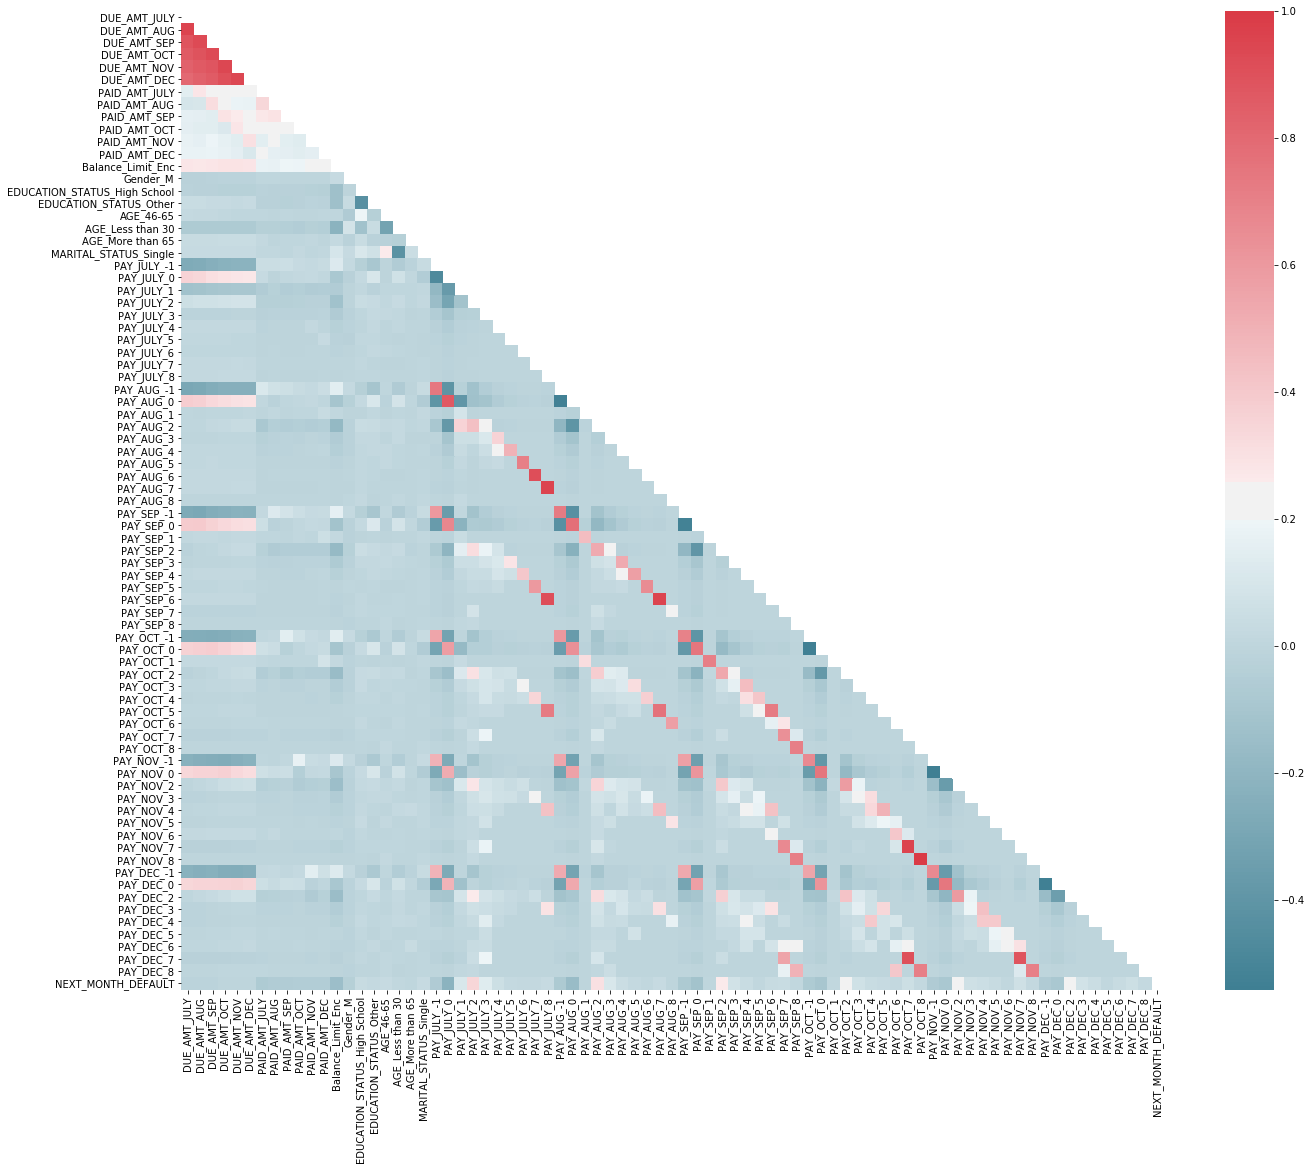

In [21]:
import matplotlib.pyplot as plt
corr = X_train.join(y_train).corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap)

**No strong correlation with target is visible expect for some variables**

In [10]:
# train the data with XGBoostClassifier

from xgboost import XGBClassifier


model_2 = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.16,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=400, 
                      reg_alpha = 0.3,
                      max_depth=12, 
                      gamma=10)


model_2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=10,
              learning_rate=0.16, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=0.8, verbosity=1)

In [29]:
#evaluating the classifier

from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
y_pred = model_2.predict(X_val)
y_train_pred = model_2.predict(X_train)

from sklearn.metrics import classification_report

target_names = ['0','1']
print(classification_report(y_val, y_pred, target_names=target_names))

print('validation f1_score ',f1_score(y_val,y_pred,average="weighted"))
print('train f1_score ',f1_score(y_train,y_train_pred,average="weighted"))


              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3745
           1       0.70      0.37      0.48      1055

    accuracy                           0.83      4800
   macro avg       0.77      0.66      0.69      4800
weighted avg       0.81      0.83      0.80      4800

validation f1_score  0.8047066694392836
train f1_score  0.8184765128190499


**Overall f1 score seemes to be good. But for individual traget values there is a huge difference in f1 scores due to imbalance nature of the training split**

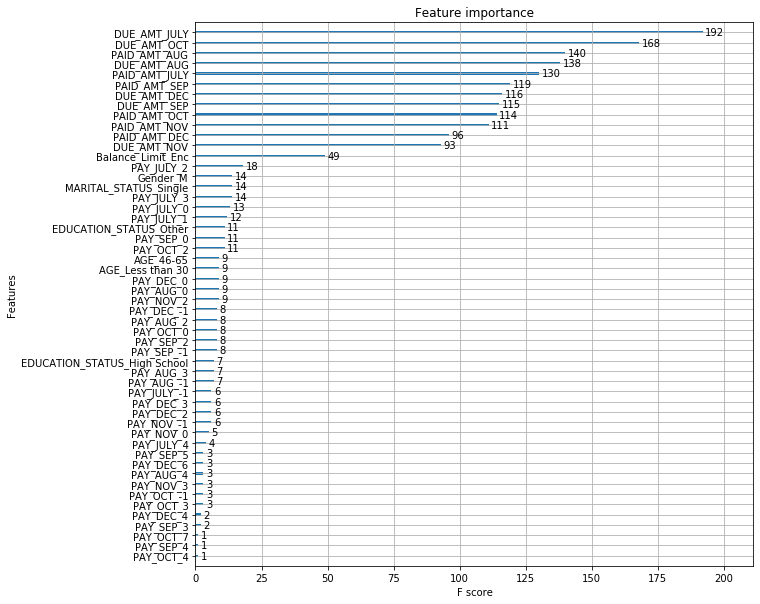

In [24]:
import xgboost as xgb
plot = xgb.plot_importance(model_2)
fig = plot.figure
fig.set_size_inches(10, 10)

**dummified featuers have not done a significant impact on the classifier**

In [0]:
#train the data with catboostClassifier

import catboost
from catboost import CatBoostClassifier

In [31]:
model_3 = CatBoostClassifier()
model_3.fit(X_train,y_train)

Learning rate set to 0.036383
0:	learn: 0.6739333	total: 15.8ms	remaining: 15.7s
1:	learn: 0.6557010	total: 30.9ms	remaining: 15.4s
2:	learn: 0.6385365	total: 46.4ms	remaining: 15.4s
3:	learn: 0.6229902	total: 61.7ms	remaining: 15.4s
4:	learn: 0.6090301	total: 77.5ms	remaining: 15.4s
5:	learn: 0.5962531	total: 93.4ms	remaining: 15.5s
6:	learn: 0.5843315	total: 109ms	remaining: 15.5s
7:	learn: 0.5734180	total: 126ms	remaining: 15.6s
8:	learn: 0.5636739	total: 141ms	remaining: 15.6s
9:	learn: 0.5543194	total: 157ms	remaining: 15.6s
10:	learn: 0.5459959	total: 173ms	remaining: 15.6s
11:	learn: 0.5378932	total: 189ms	remaining: 15.6s
12:	learn: 0.5303792	total: 210ms	remaining: 15.9s
13:	learn: 0.5239323	total: 226ms	remaining: 15.9s
14:	learn: 0.5177083	total: 241ms	remaining: 15.8s
15:	learn: 0.5120518	total: 257ms	remaining: 15.8s
16:	learn: 0.5065584	total: 273ms	remaining: 15.8s
17:	learn: 0.5018737	total: 287ms	remaining: 15.7s
18:	learn: 0.4972130	total: 302ms	remaining: 15.6s
19:	l

In [32]:
y_pred = model_3.predict(X_val)
y_train_pred = model_3.predict(X_train)

from sklearn.metrics import classification_report

target_names = ['0','1']
print(classification_report(y_val, y_pred, target_names=target_names))

print('validation f1_score ',f1_score(y_val,y_pred,average="weighted"))
print('train f1_score ',f1_score(y_train,y_train_pred,average="weighted"))


              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3745
           1       0.71      0.37      0.49      1055

    accuracy                           0.83      4800
   macro avg       0.78      0.66      0.69      4800
weighted avg       0.81      0.83      0.81      4800

validation f1_score  0.806915625
train f1_score  0.8351005351553166


**Overall f1 score seemes to be better than XGBoostClassifier. But for individual traget values there is a huge difference in f1 scores due to imbalance nature of the training split**

**The feature Engineering done was not much successful**